In [ ]:
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Transforms
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [4]:
# Load dataset
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Corn_Image_Dataset', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [5]:
# Load pretrained ResNet
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


In [6]:

num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [7]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
num_epochs = 10
train_losses = []
train_accuracies = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch 1/10 - Loss: 0.0754, Accuracy: 0.9781
Epoch 2/10 - Loss: 0.0483, Accuracy: 0.9876
Epoch 3/10 - Loss: 0.0241, Accuracy: 0.9943
Epoch 4/10 - Loss: 0.0275, Accuracy: 0.9895
Epoch 5/10 - Loss: 0.0346, Accuracy: 0.9905
Epoch 6/10 - Loss: 0.0125, Accuracy: 0.9952
Epoch 7/10 - Loss: 0.0263, Accuracy: 0.9924
Epoch 8/10 - Loss: 0.0068, Accuracy: 0.9971
Epoch 9/10 - Loss: 0.0118, Accuracy: 0.9952
Epoch 10/10 - Loss: 0.0092, Accuracy: 0.9962


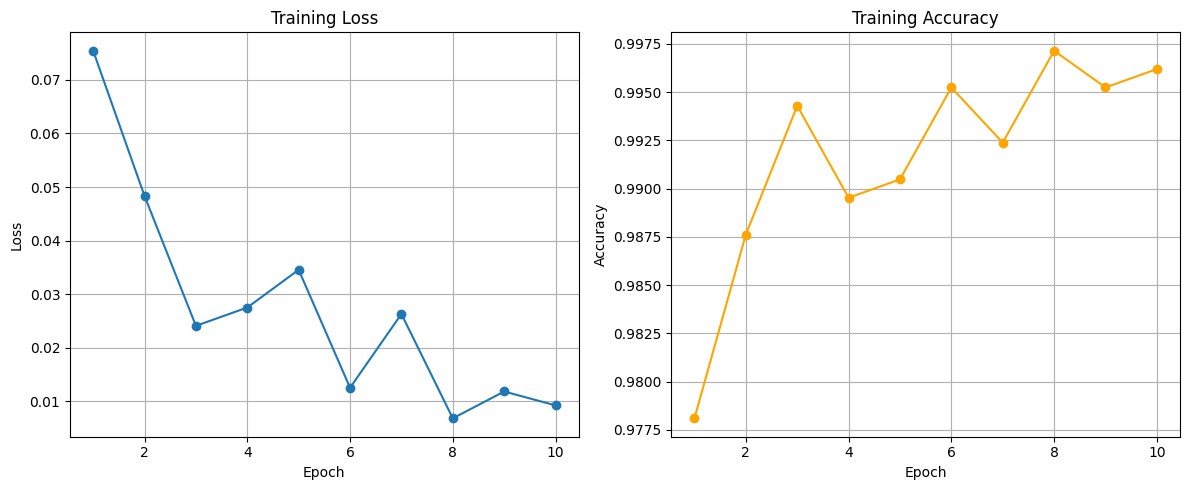

In [11]:
import matplotlib.pyplot as plt
# -------------------------------
# Plot Loss and Accuracy
# -------------------------------
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
# Accuracy
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

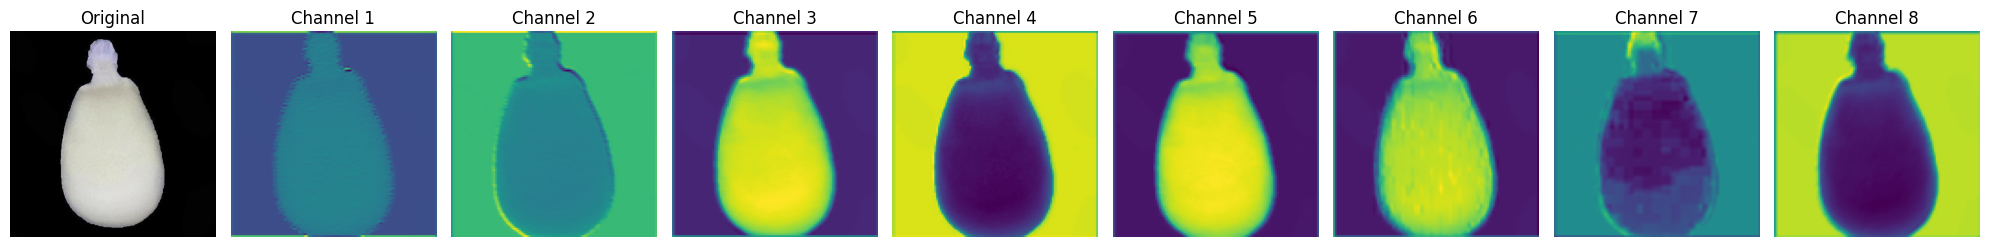

In [14]:
import matplotlib.pyplot as plt
import torch
import cv2
from PIL import Image

# Assume `model` is your pretrained ResNet
layer = model.conv1  # First convolutional layer

# Load image using OpenCV
img = cv2.imread('/content/drive/MyDrive/Corn_Image_Dataset/Zea_mays_Chulpi_Cancha/chulpi_cancha 1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB

# Convert to PIL for transforms
img_pil = Image.fromarray(img_rgb)

# Apply your transforms
img_tensor = data_transforms(img_pil).unsqueeze(0)  # shape: [1, 3, H, W]

# Forward pass through first conv layer
with torch.no_grad():
    activation = layer(img_tensor)

# Convert activation to numpy
activation = activation.squeeze(0).numpy()  # shape: [channels, H, W]

# Plot original image + first 8 channels
fig, axes = plt.subplots(1, 9, figsize=(20, 4))
# Original image
axes[0].imshow(img_rgb)
axes[0].set_title("Original")
axes[0].axis('off')

# First 8 activation channels
for i in range(8):
    axes[i+1].imshow(activation[i], cmap='viridis')
    axes[i+1].set_title(f"Channel {i+1}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()
